In [ ]:
# libs import
# Algebra
import numpy as np

# Dataframe
import pandas as pd

# Path
import os

# Missing Analysis
import missingno as msno

# Modelling
from scipy import integrate
from scipy import optimize

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# list files in the dir
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
Confirmed = pd.read_csv('/kaggle/input/corona-virus-time-series-dataset/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
Death = pd.read_csv('/kaggle/input/corona-virus-time-series-dataset/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
Recovered = pd.read_csv('/kaggle/input/corona-virus-time-series-dataset/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

Confirmed.drop(axis = 1, inplace = True, columns = ['Province/State', 'Lat', 'Long'])
Death.drop(axis = 1, inplace = True, columns = ['Province/State', 'Lat', 'Long'])
Recovered.drop(axis = 1, inplace = True, columns = ['Province/State', 'Lat', 'Long'])

In [ ]:
ind_confirmed = Confirmed[Confirmed['Country/Region'] == 'India']
ind_confirmed = ind_confirmed.T.reset_index()
ind_confirmed = ind_confirmed.iloc[1:]
ind_confirmed.columns = ['date', 'infected']

ind_death = Death[Death['Country/Region'] == 'India']
ind_death = ind_death.T.reset_index()
ind_death = ind_death.iloc[1:]
ind_death.columns = ['date', 'death']

ind_recovered = Recovered[Recovered['Country/Region'] == 'India']
ind_recovered = ind_recovered.T.reset_index()
ind_recovered = ind_recovered.iloc[1:]
ind_recovered.columns = ['date', 'recovered']

ind_statu = ind_confirmed.join(ind_death.set_index('date'), on = 'date')
ind_status = ind_statu.join(ind_recovered.set_index('date'), on = 'date')
ind_status.reset_index(inplace = True, drop = True)

In [ ]:
## 13th May, 2020
ind_status.tail()

# The modified SEIR Model


In a closed population without births or deaths, the SEIR model is:

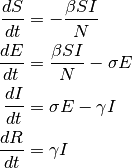

(Taken from Baiyan Ren's nice work in Kaggle)

In the case of COVID-19, the viral carriers ("exposed" population) do not exhibit symptoms, yet are infectious. So, the SEIR model is modified as below:

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}S&space;}{\mathrm{d}&space;t}=&space;-\frac{\beta&space;S(I&plus;E)}{N}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}S&space;}{\mathrm{d}&space;t}=&space;-\frac{\beta&space;S(I&plus;E)}{N}" title="\frac{\mathrm{d}S }{\mathrm{d} t}= -\frac{\beta S(I+E)}{N}" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}E&space;}{\mathrm{d}&space;t}=\frac{\beta&space;S(I&plus;E)}{N}-\sigma&space;E" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}E&space;}{\mathrm{d}&space;t}=\frac{\beta&space;S(I&plus;E)}{N}-\sigma&space;E" title="\frac{\mathrm{d}E }{\mathrm{d} t}=\frac{\beta S(I+E)}{N}-\sigma E" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}I&space;}{\mathrm{d}&space;t}=\sigma&space;E-\gamma&space;I" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}I&space;}{\mathrm{d}&space;t}=\sigma&space;E-\gamma&space;I" title="\frac{\mathrm{d}I }{\mathrm{d} t}=\sigma E-\gamma I" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}R&space;}{\mathrm{d}&space;t}=&space;\gamma&space;I" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}R&space;}{\mathrm{d}&space;t}=&space;\gamma&space;I" title="\frac{\mathrm{d}R }{\mathrm{d} t}= \gamma I" /></a>

In [ ]:
# FUNCTION 
def seir_model_ode(y, t, params): 
    '''
    Arguments:
    - y: dependent variables
    - t: independent variable (time)
    - params: Model parameters
    '''
    # Parameters to find
    infection_rate = params[0]
    recovery_rate = params[1]
    exposed_rate = params[2]

    # Y variables
    s = y[0]
    e = y[1]
    i = y[2]
    r = y[3]

    # SIR EDO System 
    dsdt = -exposed_rate * s * (i + e) 
    dedt = (exposed_rate * s * (i + e)) - (infection_rate * e)
    didt = (infection_rate * e) - (recovery_rate * i)
    drdt = recovery_rate * i

    # Return our system
    return (dsdt, dedt, didt, drdt)

In [ ]:
# FUNCTION - Calculate SEIR Model in t (time as days) based on given parameters
def calculate_seir_model(params, t, initial_condition):
    # Create an alias to our seir ode model to pass params to try
    seir_ode = lambda y, t:seir_model_ode(y, t, params)

    # Calculate ode solution, return values to each
    ode_result = integrate.odeint(func = seir_ode, y0 = initial_condition, t = t)

    # Return results
    return ode_result

In [ ]:
# FUNCTION - Auxiliary function to find the best parameters
def fit_seir_model(params_to_fit, t, initial_condition, i_r_true):
    # Calculate ODE solution for possible parameter, return values to each dependent variable:
    # (s, e, i and r)
    fit_result = calculate_seir_model(params_to_fit, t, initial_condition)

    # Calculate residual value between predicted VS true
    ## Note: ode_result[0] is S result
    residual_i = i_r_true[0] - fit_result[:, 2]
    residual_r = i_r_true[1] - fit_result[:, 3]

    # Create a np.array of all residual values for both (i) and (r)
    residual = np.concatenate((residual_i, residual_r))

    # Return results
    return residual

In [ ]:
def countryLockdown(N, status, lockdownDay, countryName):
    """inputs:
    N: population in the country
    status: dataframe of the country
    lockdownDay: number of days since begining of data to the date of lockdown
    """
    # Define Initial Condition (necessary for ODE solve)
    I_start = status.loc[0, 'infected'] / N
    E_start = (status.loc[14, 'infected'] - status.loc[0, 'infected']) / N
    S_start = 1 - E_start - I_start
    R_start = status.loc[0, 'recovered'] / N

    ## Set this values as a tuple
    ic = (S_start, E_start, I_start, R_start)

    # Create a tuple with the true values in fraction for Infected / Recovered cases (necessary for error measurement)
    beforelockdown = status.loc[0:lockdownDay]
    afterlockdown = status.loc[lockdownDay + 1: ]
    i_r_true_bf = (list(beforelockdown['infected'] / N), list(beforelockdown['recovered'] / N))
    i_r_true_af = (list(afterlockdown['infected'] / N), list(afterlockdown['recovered'] / N))

    # Define a time array measure in days
    time_opt_bf = range(0, lockdownDay + 1)
    time_opt_af = range(0, len(afterlockdown))
    time_opt = range(0, len(status))

    # define initial condition after lockdown
    I_start_af = status.loc[len(beforelockdown), 'infected'] / N
    E_start_day = min(len(status['date']),len(beforelockdown) + 14)
    E_start_af = (status.loc[E_start_day, 'infected'] - status.loc[len(beforelockdown), 'infected']) / N
    S_start_af = 1 - E_start_af - I_start_af
    R_start_af = status.loc[len(beforelockdown), 'recovered'] / N

    ## Set this values as a tuple
    ic_af = (S_start_af, E_start_af, I_start_af, R_start_af)

    # Define a start guess for our parameters [infection_rate, recovered rate]
    params_start_guess = [0.01, 0.001, 0.01]
    optimal_params, sucess = optimize.leastsq(fit_seir_model,
                                              x0 = params_start_guess,
                                              args =(time_opt_bf, ic, i_r_true_bf),
                                              ftol = 1.49012e-15)
    optimal_params_af, sucess = optimize.leastsq(fit_seir_model,
                                                 x0 = params_start_guess,
                                                 args = (time_opt_af, ic_af, i_r_true_af),
                                                 ftol = 1.49012e-15)
    print('## ' + countryName + ' before lockdown')
    print('Optimised infection rate: ', optimal_params[0])
    print('Optimised recovered rate: ', optimal_params[1])
    print('Optimised exposed rate: ', optimal_params[2])
    print('## ' + countryName + ' after lockdown')
    print('Optimised infection rate: ', optimal_params_af[0])
    print('Optimised recovered rate: ', optimal_params_af[1])
    print('Optimised exposed rate: ', optimal_params_af[2])

    # Fit test
    ## Get the optimal parameters
    ir = optimal_params[0]
    rr = optimal_params[1]
    er = optimal_params[2]
    ir_af = optimal_params_af[0]
    rr_af = optimal_params_af[1]
    er_af = optimal_params_af[2]

    ## Calculate a curve based on those parameters
    fit_result_bf = calculate_seir_model((ir, rr, er), time_opt_bf, ic)
    fit_result_af = calculate_seir_model((ir_af, rr_af, er_af), time_opt_af, ic_af)

    ## Define plot object
    plt.figure(figsize = [12, 7])

    ## Plot real and predicted infected
    plt.plot(time_opt, i_r_true_bf[0] + i_r_true_af[0], 'ro', markersize = 1)
    plt.plot(time_opt, np.hstack((fit_result_bf[:, 2], fit_result_af[:, 2])), 'c')
    plt.legend(['True infected', 'Predicted infection'], loc = 2, fontsize = 8)
    plt.title('Infected - ' + countryName, fontsize = 20)
    plt.xlabel('Days since 30-01-2020', fontsize = 12)
    plt.ylabel('Population', fontsize = 12)

    ## Plot real and predicted recovered
    plt.figure(figsize = [12, 7])
    plt.plot(time_opt, i_r_true_bf[1]+i_r_true_af[1], 'ro', markersize = 1)
    plt.plot(time_opt, np.hstack((fit_result_bf[:, 3], fit_result_af[:, 3])), 'g')
    plt.legend(['Real recovered', 'Predicted recovered'], loc = 2, fontsize = 8)
    plt.title('Recovered - ' + countryName, fontsize = 20);
    plt.xlabel('Days since 30-01-2020', fontsize = 12)
    plt.ylabel('Population', fontsize = 12)

    # Prediction
    ## Get prediction full period time in datetime object and the convert to string
    datetime_pred = pd.date_range(start = "2020-02-01",end = "2021-01-01", freq = 'D')
    pred_time = [x.strftime("%Y-%m-%d") for x in datetime_pred]
    pred_range = range(0, len(pred_time))
    pred_result = calculate_seir_model((ir_af, rr_af, er_af), pred_range, ic_af)
    pred_death = (pred_result[:, 1] + pred_result[:, 2]) * 0.03 # based on 3% death rate
    time_axis = [pred_time[i] for i in[0, 29, 60, 90, 121, 151, 182, 213, 243, 274, 304, 335]]
    time_labels = ['Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.', 'Jan.']

    ## Plot SEIR
    plt.figure(figsize = [12, 7])
    plt.plot(pred_time, pred_result[:, 0], color = 'blue') # susceptible
    plt.plot(pred_time, pred_result[:, 1], color = 'red') # exposed
    plt.plot(pred_time, pred_result[:, 2], color = 'cyan') # infected
    plt.plot(pred_time, pred_result[:, 3], color = 'green') # recovered
    plt.plot(pred_time, pred_death, color = 'black')
    plt.legend(loc = 1, labels = ['Susceptible', 'Exposed', 'Infected', 'Recovered', 'Death'], fontsize = 8)
    plt.title('SEIR predictions', fontsize = 20)
    plt.xlabel('Month', fontsize = 12)
    plt.ylabel('Proportion of population', fontsize = 12)
    plt.xticks(time_axis, time_labels, rotation = 'vertical');

In [ ]:
def countryNolockdown(N, status, countryName):
    # Define Initial Condition (necessary for ODE solve)
    I_start = status.loc[0, 'infected'] / N
    E_start = (status.loc[14, 'infected'] - status.loc[0, 'infected']) / N
    S_start = 1 - E_start - I_start
    R_start = status.loc[0, 'recovered'] / N

    ## Set this values as a tuple
    ic = (S_start, E_start, I_start, R_start)
    i_r_true = (list(status['infected'] / N), list(status['recovered'] / N))
    time_opt = range(0, len(status))

    # Define a start guess for our parameters [infection_rate, recovered rate]
    params_start_guess = [0.01, 0.001, 0.01]
    optimal_params, sucess = optimize.leastsq(fit_seir_model,
                                              x0 = params_start_guess,
                                              args =(time_opt, ic, i_r_true),
                                              ftol = 1.49012e-15)
    print('## ' + countryName)
    print('Optimised infection rate: ', optimal_params[0])
    print('Optimised recovered rate: ', optimal_params[1])
    print('Optimised exposed rate: ', optimal_params[2])

    # Get the optimal parameters
    ir = optimal_params[0]
    rr = optimal_params[1]
    er = optimal_params[2]
    fit_result = calculate_seir_model((ir, rr, er), time_opt, ic)

    # Plot the results for Infected / Recovered
    ## Define plot object
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize =(20, 10))

    ## Plot process
    axes[0].plot(time_opt, i_r_true[0], 'ro')
    axes[0].plot(time_opt, fit_result[:, 2], 'p')
    axes[0].legend(['Observed', 'Predicted'], loc = 2, fontsize = 15)
    axes[0].set_title('Infected cases - ' + countryName, fontsize = 20)
    axes[1].plot(time_opt, i_r_true[1], 'ro')
    axes[1].plot(time_opt, fit_result[:, 3], 'p')
    axes[1].legend(['Observed', 'Predicted'], loc = 2, fontsize = 15)
    axes[1].set_title('Recovered cases - ' + countryName, fontsize = 20);
    plt.show()
    
    # Prediction
    datetime_pred = pd.date_range(start = "2020-02-01", end = "2021-01-01", freq = 'D')
    pred_time = [x.strftime("%Y-%m-%d") for x in datetime_pred]
    pred_range = range(0, len(pred_time))
    pred_result = calculate_seir_model((ir, rr, er), pred_range, ic)
    pred_death = (pred_result[:, 1] + pred_result[:, 2]) * 0.03 # predict icu requirement based on 3% death rate
    time_axis = [pred_time[i] for i in[0, 30, 61, 91, 122, 153, 183, 214, 244, 274]]

    ## Plot SEIR
    plt.figure(figsize = [12, 7])
    plt.plot(pred_time, pred_result[:, 0], color = 'blue') 
    plt.plot(pred_time, pred_result[:, 1], color = 'red')
    plt.plot(pred_time, pred_result[:, 2], color = 'purple')
    plt.plot(pred_time, pred_result[:, 3], color = 'green')
    plt.plot(pred_time, pred_death, color = 'black')
    plt.legend(loc = 1, labels = ['Susceptible', 'Exposed', 'Infected', 'Recovered', 'Death'], fontsize = 10)
    plt.title('SEIR predictions', fontsize = 20)
    plt.xlabel('Date', fontsize = 15)
    plt.ylabel('Total cases', fontsize = 15)
    plt.xticks(time_axis)

# India / Bharot

In [ ]:
countryLockdown(1.38 * 1e9, ind_status, 63, 'India')